# Shakespeare Character Genders

Replicating [Determining the Gender of Shakespeare’s Characters by Matt Olson](http://cs229.stanford.edu/proj2013/Olson-DeterminingTheGenderOfShakespearesCharacters.pdf).

## Imports

In [1]:
from os import listdir
from bs4 import BeautifulSoup
import pandas as pd
from nltk.tokenize import word_tokenize
import numpy as np
from nltk.corpus import stopwords
import math
import matplotlib.pyplot as plt

## Data Loading

### Load Gender Labels

In [2]:
df = pd.read_csv('all_globe_name_id.csv', 
            header=None, 
            names=['role_id', 'role', 'file_name', 'blank', 'gender', 'initials'])
df = df.drop(labels=['blank', 'initials'], axis=1)

In [3]:
df['gender'] = df['gender'].str.upper()

In [4]:
df['speech_count'] = 0
df['total_words'] = 0
df

,role_id,role,file_name,gender,speech_count,total_words
0,tim.,TIMON of Athens,Globe_Shakespeare/tim.xml,MALE,0,0
1,lucul.,LUCULLUS,Globe_Shakespeare/tim.xml,MALE,0,0
2,sem.,SEMPRONIUS,Globe_Shakespeare/tim.xml,MALE,0,0
3,ven.,VENTIDIUS,Globe_Shakespeare/tim.xml,MALE,0,0
4,alcib.,ALCIBIADES,Globe_Shakespeare/tim.xml,MALE,0,0
...,...,...,...,...,...,...
1116,serv.,Servant,Globe_Shakespeare/ham.xml,MALE,0,0
1117,sail.,Sailor,Globe_Shakespeare/ham.xml,MALE,0,0
1118,mess.,Mess.,Globe_Shakespeare/ham.xml,MALE,0,0
1119,lord.,Lord.,Globe_Shakespeare/ham.xml,MALE,0,0


## Files

In [5]:
files = [f for f in listdir('Globe_Shakespeare')]

In [6]:
base = 'Globe_Shakespeare/'

for file in files:
    file_name = base + file
    with open(file_name, 'r') as tei:
        soup = BeautifulSoup(tei, 'lxml')

        for speech in soup.find_all('sp'):
            for tag in speech.find_all(['stage', 'speaker']):
                tag.decompose()

            text = speech.get_text()
            words = [word for word in word_tokenize(text) if word.isalpha()]

            df.loc[(df['file_name'] == file_name) & (df['role_id'] == speech.get('who')), 'speech_count'] += 1
            df.loc[(df['file_name'] == file_name) & (df['role_id'] == speech.get('who')), 'total_words'] += len(words)

In [7]:
df['avg_words_per_speech'] = df['total_words'] / df['speech_count']
df

,role_id,role,file_name,gender,speech_count,total_words,avg_words_per_speech
0,tim.,TIMON of Athens,Globe_Shakespeare/tim.xml,MALE,210,6225,29.642857
1,lucul.,LUCULLUS,Globe_Shakespeare/tim.xml,MALE,5,191,38.200000
2,sem.,SEMPRONIUS,Globe_Shakespeare/tim.xml,MALE,2,204,102.000000
3,ven.,VENTIDIUS,Globe_Shakespeare/tim.xml,MALE,2,59,29.500000
4,alcib.,ALCIBIADES,Globe_Shakespeare/tim.xml,MALE,39,1167,29.923077
...,...,...,...,...,...,...,...
1116,serv.,Servant,Globe_Shakespeare/ham.xml,MALE,1,9,9.000000
1117,sail.,Sailor,Globe_Shakespeare/ham.xml,MALE,2,39,19.500000
1118,mess.,Mess.,Globe_Shakespeare/ham.xml,MALE,2,36,18.000000
1119,lord.,Lord.,Globe_Shakespeare/ham.xml,MALE,3,67,22.333333


In [8]:
df.to_csv('processed_data.csv')

## Read balanced data

In [9]:
balanced_data = pd.read_csv('balanced_data.csv')
balanced_data

,role_id,role,file_name,gender,speech_count,total_words,avg_words_per_speech
0,hor.,THOMAS HORNER,Globe_Shakespeare/2h6.xml,MALE,6,167,27.833333
1,ant-14,Dolabella,Globe_Shakespeare/ant.xml,MALE,23,282,12.260870
2,cor.,CORIN,Globe_Shakespeare/ayl.xml,MALE,24,550,22.916667
3,patr.,PATROCLUS,Globe_Shakespeare/tro.xml,MALE,37,401,10.837838
4,lor.,LORENZO,Globe_Shakespeare/mv.xml,MALE,47,1312,27.914894
...,...,...,...,...,...,...,...
205,jul.,JULIET,Globe_Shakespeare/rom.xml,FEMALE,118,4206,35.644068
206,isab.,ISABELLA,Globe_Shakespeare/mm.xml,FEMALE,129,2972,23.038760
207,des.,DESDEMONA,Globe_Shakespeare/oth.xml,FEMALE,165,2729,16.539394
208,ros.,ROSALIND,Globe_Shakespeare/ayl.xml,FEMALE,201,5648,28.099502


In [10]:
role_id_file_name_to_speeches = {}

for index, row in balanced_data.iterrows():
    role_id_file_name_to_speeches[(row['role_id'], row['file_name'])] = []

## Collect speeches

In [11]:
base = 'Globe_Shakespeare/'

for file in files:
    file_name = base + file
    with open(file_name, 'r') as tei:
        soup = BeautifulSoup(tei, 'lxml')

        for speech in soup.find_all('sp'):
            for tag in speech.find_all(['stage', 'speaker']):
                tag.decompose()

            text = speech.get_text()
            words = [word for word in word_tokenize(text) if word.isalpha()]
            
            if speech.get('who') is not None and (speech.get('who'), file_name) in role_id_file_name_to_speeches:
                role_id_file_name_to_speeches[(speech.get('who'), file_name)].append(words)

## Create frequency matrix

In [12]:
words = set()
for role_id_file_name, speeches in role_id_file_name_to_speeches.items():
    for speech in speeches:
        for word in speech:
            words.add(word.lower())

In [13]:
role_id_file_name_to_word_to_count = {}
for role_id_file_name, speeches in role_id_file_name_to_speeches.items():
    word_to_count = {}
    
    for speech in speeches:
        for word in speech:
            if word_to_count.get(word.lower()) is None:
                word_to_count[word.lower()] = 1
            else:
                word_to_count[word.lower()] = word_to_count.get(word.lower()) + 1

    role_id_file_name_to_word_to_count[role_id_file_name] = word_to_count

In [14]:
frequency_matrix = pd.DataFrame(0, index=role_id_file_name_to_speeches.keys(), columns=words)
frequency_matrix

,,wherever,stricter,league,only,slanderer,unspotted,caps,bloom,tom,inconstancy,...,merrier,gorgeous,remuneration,basin,dispersed,dwellest,prognostication,sworn,weather,gallop
hor.,Globe_Shakespeare/2h6.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ant-14,Globe_Shakespeare/ant.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cor.,Globe_Shakespeare/ayl.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
patr.,Globe_Shakespeare/tro.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
lor.,Globe_Shakespeare/mv.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
jul.,Globe_Shakespeare/rom.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
isab.,Globe_Shakespeare/mm.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
des.,Globe_Shakespeare/oth.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ros.,Globe_Shakespeare/ayl.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
for role_id_file_name, word_to_count in role_id_file_name_to_word_to_count.items():
    for word, count in word_to_count.items():
        frequency_matrix.loc[role_id_file_name, word] += count

frequency_matrix

,,wherever,stricter,league,only,slanderer,unspotted,caps,bloom,tom,inconstancy,...,merrier,gorgeous,remuneration,basin,dispersed,dwellest,prognostication,sworn,weather,gallop
hor.,Globe_Shakespeare/2h6.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ant-14,Globe_Shakespeare/ant.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
cor.,Globe_Shakespeare/ayl.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
patr.,Globe_Shakespeare/tro.xml,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
lor.,Globe_Shakespeare/mv.xml,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
jul.,Globe_Shakespeare/rom.xml,0,0,0,2,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
isab.,Globe_Shakespeare/mm.xml,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
des.,Globe_Shakespeare/oth.xml,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ros.,Globe_Shakespeare/ayl.xml,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


## Top 800 words

In [16]:
counts = frequency_matrix.sum(axis=0)

top_words = []
for word in counts.index:
    if counts[word] >= 800:
        top_words.append(word)

top_words

['you',
 'my',
 'i',
 'o',
 'the',
 'not',
 'we',
 'this',
 'thee',
 'if',
 'me',
 'that',
 'it',
 'as',
 'thy',
 'will',
 'is',
 'so',
 'all',
 'he',
 'do',
 'good',
 'have',
 'by',
 'a',
 'in',
 'for',
 'with',
 'thou',
 'your',
 'to',
 'but',
 'are',
 'her',
 'of',
 'shall',
 'his',
 'him',
 'and',
 'no',
 'be',
 'on',
 'what']

In [17]:
balanced_data.loc[(balanced_data['role_id'] == 'hor.') & (balanced_data['file_name'] == 'Globe_Shakespeare/2h6.xml')]



# df.loc[(df['file_name'] == file_name) & (df['role_id'] == speech.get('who')), 'speech_count']

,role_id,role,file_name,gender,speech_count,total_words,avg_words_per_speech
0,hor.,THOMAS HORNER,Globe_Shakespeare/2h6.xml,MALE,6,167,27.833333


In [18]:
total_word_count_men = 0
total_word_count_women = 0

top_word_count_men = {}
top_word_count_women = {}

for top_word in top_words:
    top_word_count_men[top_word] = 0
    top_word_count_women[top_word] = 0

for role_id_file_name, speeches in role_id_file_name_to_speeches.items():
    gender = balanced_data.loc[(balanced_data['role_id'] == role_id_file_name[0]) & (balanced_data['file_name'] == role_id_file_name[1]), 'gender']
    
    for speech in speeches:
        
        # Count the total words
        if gender.values[0] == 'MALE':
            total_word_count_men += len(speech)
        elif gender.values[0] == 'FEMALE':
            total_word_count_women += len(speech)
        
        for word in speech:
            if word.lower() in top_words:
                if gender.values[0] == 'MALE':
                    top_word_count_men[word.lower()] += 1
                elif gender.values[0] == 'FEMALE':
                    top_word_count_women[word.lower()] += 1

print('Total word count men', total_word_count_men)
print('Total word count women', total_word_count_women)
print('Top word count men:', top_word_count_men)
print('Top word count women:', top_word_count_women)

Total word count men 107154
Total word count women 115664
Top word count men: {'you': 1794, 'my': 1392, 'i': 2855, 'o': 339, 'the': 3813, 'not': 1197, 'we': 513, 'this': 933, 'thee': 371, 'if': 496, 'me': 928, 'that': 1395, 'it': 1041, 'as': 769, 'thy': 445, 'will': 654, 'is': 1409, 'so': 620, 'all': 541, 'he': 959, 'do': 466, 'good': 371, 'have': 741, 'by': 588, 'a': 1941, 'in': 1518, 'for': 1064, 'with': 932, 'thou': 750, 'your': 864, 'to': 2492, 'but': 790, 'are': 454, 'her': 501, 'of': 2147, 'shall': 512, 'his': 880, 'him': 689, 'and': 3161, 'no': 520, 'be': 868, 'on': 421, 'what': 644}
Top word count women: {'you': 2361, 'my': 2010, 'i': 3618, 'o': 568, 'the': 3222, 'not': 1498, 'we': 362, 'this': 800, 'thee': 456, 'if': 576, 'me': 1436, 'that': 1750, 'it': 1181, 'as': 828, 'thy': 576, 'will': 727, 'is': 1486, 'so': 800, 'all': 516, 'he': 1035, 'do': 621, 'good': 491, 'have': 882, 'by': 501, 'a': 1996, 'in': 1375, 'for': 1077, 'with': 1025, 'thou': 850, 'your': 1067, 'to': 2602, '

In [19]:
percent_men = {}

for top_word in top_words:
    percent_men[top_word] = top_word_count_men[top_word] / (top_word_count_men[top_word] + top_word_count_women[top_word])

print('Percent usage by men:', percent_men)

Percent usage by men: {'you': 0.43176895306859203, 'my': 0.4091710758377425, 'i': 0.4410628765641897, 'o': 0.3737596471885336, 'the': 0.5420042643923241, 'not': 0.44415584415584414, 'we': 0.5862857142857143, 'this': 0.5383727639930755, 'thee': 0.4486094316807739, 'if': 0.4626865671641791, 'me': 0.3925549915397631, 'that': 0.4435612082670906, 'it': 0.4684968496849685, 'as': 0.4815278647463995, 'thy': 0.435847208619001, 'will': 0.47356987690079655, 'is': 0.4867012089810017, 'so': 0.43661971830985913, 'all': 0.5118259224219489, 'he': 0.4809428284854564, 'do': 0.42870285188592455, 'good': 0.43039443155452434, 'have': 0.4565619223659889, 'by': 0.5399449035812672, 'a': 0.49301498602997207, 'in': 0.5247148288973384, 'for': 0.4969640354974311, 'with': 0.4762391415431783, 'thou': 0.46875, 'your': 0.44743656136716725, 'to': 0.48920298390263056, 'but': 0.44158747903856904, 'are': 0.47340980187695514, 'her': 0.47488151658767774, 'of': 0.5222573583069813, 'shall': 0.540084388185654, 'his': 0.509849

Find the top 15 most gender-imbalanced words.

In [25]:
top_imbalanced_percent_men = sorted(percent_men.items(), key = lambda kv:(abs(0.5 - kv[1]), kv[0]), reverse = True)[:15]
top_imbalanced_percent_men = sorted(top_imbalanced, key = lambda kv:(kv[1]))
top_imbalanced_percent_men

[('o', 0.3737596471885336),
 ('me', 0.3925549915397631),
 ('my', 0.4091710758377425),
 ('do', 0.42870285188592455),
 ('good', 0.43039443155452434),
 ('you', 0.43176895306859203),
 ('thy', 0.435847208619001),
 ('so', 0.43661971830985913),
 ('i', 0.4410628765641897),
 ('but', 0.44158747903856904),
 ('that', 0.4435612082670906),
 ('not', 0.44415584415584414),
 ('be', 0.4460431654676259),
 ('your', 0.44743656136716725),
 ('we', 0.5862857142857143)]

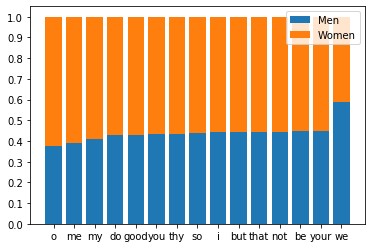

In [34]:
words = []
percent_men_values = []
percent_women_values = []

for word, percent_men in top_imbalanced_percent_men:
    words.append(word)
    percent_men_values.append(percent_men)
    percent_women_values.append(1 - percent_men)

ind = np.arange(len(words))

p1 = plt.bar(ind, percent_men_values)
p2 = plt.bar(ind, percent_women_values, bottom=percent_men_values)

plt.xticks(ind, words)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend((p1[0], p2[0]), ('Men', 'Women'))
plt.show()